# Modelling 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

**Importing data sets to use**

In [2]:
df = pd.read_csv('wf_final_df.csv')

In [3]:
wf = pd.read_csv('sp500_stock_20_22_close_with_sector_wide_format.csv')

**Getting the april 2023 data**

In [4]:
df_april = pd.read_csv('Data/sp500_stock_april_close_with_sector_wide_format.csv')

In [5]:
df_april.columns.values[2:] = ['days_from_' + str(d).zfill(2) for d in range(1, 62+1)]

In [6]:
df_april_use = df_use = df_april.loc[:, ['symbol', 'days_from_62']]

**Setting the relative closing price for April 2023 compared to Jan 1 2020**

In [7]:
temp_df = wf.set_index('symbol').join(df_april_use.set_index('symbol'), on='symbol', how='left').reset_index()

In [8]:
temp_df['apr_rel_close'] = (temp_df.days_from_62 - temp_df.day_001) / temp_df.day_001

**Getting the final data to use ready and adding the april relative closing price**

In [9]:
df_use = df.copy().drop('Unnamed: 0', axis=1)

In [10]:
df_use['apr_rel_close'] = temp_df.apr_rel_close

**Importing Required Modules**

In [11]:
import statsmodels.formula.api as smf

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

In [13]:
from sklearn.pipeline import Pipeline

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
my_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=101)

In [16]:
from sklearn.preprocessing import OneHotEncoder

In [17]:
from sklearn.compose import ColumnTransformer

In [18]:
from patsy import dmatrices

In [19]:
import time

In [20]:
from sklearn.decomposition import PCA

In [21]:
import pickle

### Model - 1 
**Using only 2020 data and output as April-1 2021 (3 months from Dec 2020)**

In [22]:
mod1_days = ['day_' + str(d).zfill(3) for d in range(1,252+1)]

In [23]:
mod1_df = df_use.loc[:, ['sector'] + mod1_days ].copy()

In [24]:
mod1_df['outcome'] = np.where( df_use.day_316 > df_use.day_252, 'event', 'non-event')

In [25]:
mod1_df.outcome.value_counts(normalize=True)

event        0.856
non-event    0.144
Name: outcome, dtype: float64

In [26]:
mod1_inputs_df = mod1_df.loc[:, ['sector'] + mod1_days].copy()

In [27]:
mod1_output_df = mod1_df.loc[:, ['outcome']].copy()

In [28]:
mod1_ytrain = mod1_output_df.outcome.to_numpy().ravel()

In [29]:
mod1_num_transform = Pipeline( steps=[ ('std_input', StandardScaler()) ])

In [30]:
mod1_cat_input = mod1_inputs_df.select_dtypes('object').columns.to_list()

In [31]:
mod1_cat_transform = Pipeline( steps= [ ('dummy', OneHotEncoder(drop='first')) ])

In [32]:
mod1_prepro_transform = ColumnTransformer(transformers= [ ('num', mod1_num_transform, mod1_days),
                                                          ('cat', mod1_cat_transform, mod1_cat_input)])

In [33]:
enet_to_fit = LogisticRegression(penalty='elasticnet', solver='saga', random_state=101, max_iter=100001,
                                 fit_intercept=True)

In [34]:
enet_grid = {'enet__C': np.exp(np.linspace(-6, 6, num=11)),
             'enet__l1_ratio': np.linspace(0, 1, num=5)}

In [35]:
mod1_wflow = Pipeline(steps=[ ('prepo', mod1_prepro_transform),
                              ('enet', enet_to_fit)])

In [36]:
mod1_enet_search = GridSearchCV( mod1_wflow, enet_grid, cv=my_cv)

In [37]:
# mod1_t0 = time.time()

# mod1_enet_search_result = mod1_enet_search.fit(mod1_inputs_df, mod1_ytrain)

# mod1_t1 = time.time()

In [38]:
# (mod1_t1 - mod1_t0) / 60

**Saving model**

In [39]:
# pickle.dump(mod1_enet_search_result, open('mod1_final.sav', 'wb'))

**Loading model**

In [40]:
mod1_enet_search_result = pickle.load(open('mod1_final.sav', 'rb'))

In [41]:
mod1_enet_search_result.best_params_

{'enet__C': 0.0024787521766663585, 'enet__l1_ratio': 0.25}

In [42]:
mod1_enet_search_result.best_score_

0.8559999999999998

**Visualizing the result**

In [43]:
mod1_cv_summary = pd.DataFrame({'C': mod1_enet_search_result.cv_results_['param_enet__C'].data.astype('float64'),
                                'l1_ratio': mod1_enet_search_result.cv_results_['param_enet__l1_ratio'].data.astype('float64'),
                                'mean_test_score': mod1_enet_search_result.cv_results_['mean_test_score'],
                                'std_test_score': mod1_enet_search_result.cv_results_['std_test_score']})

In [44]:
mod1_cv_summary['mean_test_score_se'] = mod1_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [45]:
mod1_cv_summary['log_C'] = np.log( mod1_cv_summary.C )

In [46]:
mod1_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,C,l1_ratio,mean_test_score,std_test_score,mean_test_score_se,log_C
2,0.002479,0.50,0.856,0.004899,0.001265,-6.0
3,0.002479,0.75,0.856,0.004899,0.001265,-6.0
4,0.002479,1.00,0.856,0.004899,0.001265,-6.0
7,0.008230,0.50,0.856,0.004899,0.001265,-4.8
8,0.008230,0.75,0.856,0.004899,0.001265,-4.8


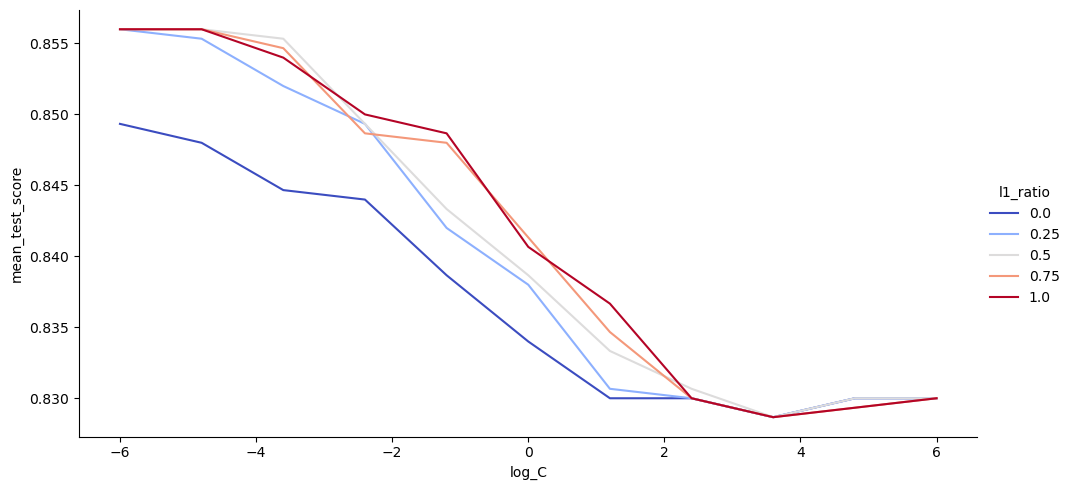

In [47]:
sns.relplot(data=mod1_cv_summary, x='log_C', y='mean_test_score', hue='l1_ratio',
           kind='line', palette='coolwarm', aspect=2)

plt.show()

**Extracting and adding the best model to a dataframe**

In [48]:
mod1_best_result = mod1_cv_summary.\
loc[mod1_cv_summary.mean_test_score == mod1_cv_summary.mean_test_score.max(), :].copy()

In [49]:
mod1_best_result['model_name'] = 'Mod-1: 2020 data'

In [50]:
mod1_best_result = mod1_best_result.\
loc[mod1_best_result.l1_ratio == mod1_best_result.l1_ratio.min(), :].copy()

In [51]:
mod1_best_result

,C,l1_ratio,mean_test_score,std_test_score,mean_test_score_se,log_C,model_name
1,0.002479,0.25,0.856,0.004899,0.001265,-6.0,Mod-1: 2020 data


### Model - 2
**Using only 2021 data and output as April-1 2022 (3 months from Dec 2021)**

In [52]:
mod2_days = ['day_' + str(d).zfill(3) for d in range(253,504+1)]

In [53]:
mod2_df = df_use.loc[:, ['sector'] + mod2_days ].copy()

In [54]:
mod2_df['outcome'] = np.where( df_use.day_568 > df_use.day_504, 'event', 'non-event')

In [55]:
mod2_df.outcome.value_counts(normalize=True)

non-event    0.592
event        0.408
Name: outcome, dtype: float64

In [56]:
mod2_formula = 'outcome ~ sector + ' + ' + '.join(mod2_days)

In [57]:
y2_check, X2_check = dmatrices(mod2_formula, data = mod2_df, return_type='dataframe')

In [58]:
X2_check.head()

,Intercept,sector[T.Consumer Discretionary],sector[T.Consumer Staples],sector[T.Energy],sector[T.Financials],sector[T.Health Care],sector[T.Industrials],sector[T.Information Technology],sector[T.Materials],sector[T.Real Estate],...,day_495,day_496,day_497,day_498,day_499,day_500,day_501,day_502,day_503,day_504
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.754509,0.761722,0.750087,0.791274,0.824084,0.835951,0.846888,0.852007,0.869110,0.871786
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.432107,-0.417326,-0.405294,-0.377106,-0.372293,-0.372293,-0.375387,-0.362668,-0.379512,-0.378824
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500282,0.460511,0.432721,0.440123,0.460322,0.456182,0.483596,0.493821,0.512013,0.489994
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.294123,1.279208,1.260696,1.303846,1.339138,1.347661,1.401598,1.387747,1.388946,1.373231
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.471580,0.446454,0.461306,0.451145,0.474595,0.486209,0.500949,0.500726,0.511558,0.517923


In [59]:
mod2_df.shape

(500, 254)

In [60]:
mod2_df.sector.nunique()

11

In [61]:
mod2_inputs_df = mod2_df.loc[:, ['sector'] + mod2_days].copy()

In [62]:
mod2_output_df = mod2_df.loc[:, ['outcome']].copy()

In [63]:
mod2_ytrain = mod2_output_df.outcome.to_numpy().ravel()

In [64]:
mod2_num_transform = Pipeline( steps=[ ('std_input', StandardScaler()) ])

In [65]:
mod2_cat_input = mod2_inputs_df.select_dtypes('object').columns.to_list()

In [66]:
mod2_cat_transform = Pipeline( steps= [ ('dummy', OneHotEncoder(drop='first')) ])

In [67]:
mod2_prepro_transform = ColumnTransformer(transformers= [ ('num', mod2_num_transform, mod2_days),
                                                          ('cat', mod2_cat_transform, mod2_cat_input)])

In [68]:
enet_to_fit = LogisticRegression(penalty='elasticnet', solver='saga', random_state=101, max_iter=100001,
                                 fit_intercept=True)

In [69]:
enet_grid = {'enet__C': np.exp(np.linspace(-6, 6, num=11)),
             'enet__l1_ratio': np.linspace(0, 1, num=5)}

In [70]:
mod2_wflow = Pipeline(steps=[ ('prepo', mod2_prepro_transform),
                              ('enet', enet_to_fit)])

In [71]:
mod2_enet_search = GridSearchCV( mod2_wflow, enet_grid, cv=my_cv)

In [72]:
# mod2_t0 = time.time()

# mod2_enet_search_result = mod2_enet_search.fit(mod2_inputs_df, mod2_ytrain)

# mod2_t1 = time.time()

In [73]:
# (mod2_t1 - mod2_t0) / 60

**Save Model**

In [74]:
# pickle.dump(mod2_enet_search_result, open('mod2_final.sav', 'wb'))

**Load Model**

In [75]:
mod2_enet_search_result = pickle.load(open('mod2_final.sav', 'rb'))

In [76]:
mod2_enet_search_result.best_params_

{'enet__C': 1.0, 'enet__l1_ratio': 0.0}

In [77]:
mod2_enet_search_result.best_score_

0.7279999999999999

**Visualizing the result**

In [78]:
mod2_cv_summary = pd.DataFrame({'C': mod2_enet_search_result.cv_results_['param_enet__C'].data.astype('float64'),
                                'l1_ratio': mod2_enet_search_result.cv_results_['param_enet__l1_ratio'].data.astype('float64'),
                                'mean_test_score': mod2_enet_search_result.cv_results_['mean_test_score'],
                                'std_test_score': mod2_enet_search_result.cv_results_['std_test_score']})

In [79]:
mod2_cv_summary['mean_test_score_se'] = mod2_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [80]:
mod2_cv_summary['log_C'] = np.log( mod2_cv_summary.C )

In [81]:
mod2_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,C,l1_ratio,mean_test_score,std_test_score,mean_test_score_se,log_C
25,1.000000,0.00,0.728000,0.035440,0.009151,0.0
31,3.320117,0.25,0.726667,0.038413,0.009918,1.2
37,11.023176,0.50,0.726667,0.039441,0.010184,2.4
38,11.023176,0.75,0.726667,0.039441,0.010184,2.4
32,3.320117,0.50,0.726667,0.037889,0.009783,1.2


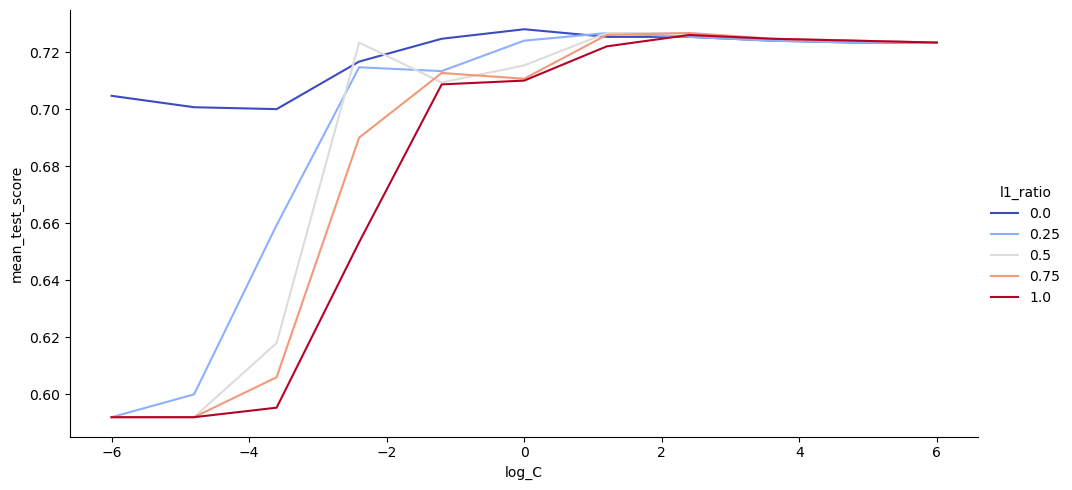

In [82]:
sns.relplot(data=mod2_cv_summary, x='log_C', y='mean_test_score', hue='l1_ratio',
           kind='line', palette='coolwarm', aspect=2)

plt.show()

**Extracting and adding the best model**

In [83]:
mod2_best_result = mod2_cv_summary.\
loc[mod2_cv_summary.mean_test_score == mod2_cv_summary.mean_test_score.max(), :].copy()

In [84]:
mod2_best_result['model_name'] = 'Mod-2: 2021 data'

In [85]:
mod2_best_result

,C,l1_ratio,mean_test_score,std_test_score,mean_test_score_se,log_C,model_name
25,1.0,0.0,0.728,0.03544,0.009151,0.0,Mod-2: 2021 data


### Model - 3
**Using only 2022 data and output as April-1 2023 (3 months from Dec 2022)**

In [86]:
mod3_days = ['day_' + str(d).zfill(3) for d in range(505,756+1)]

In [87]:
mod3_df = df_use.loc[:, ['sector'] + mod3_days ].copy()

In [88]:
mod3_df['outcome'] = np.where( df_use.apr_rel_close > df_use.day_756, 'event', 'non-event')

In [89]:
mod3_df.outcome.value_counts(normalize=True)

event        0.542
non-event    0.458
Name: outcome, dtype: float64

In [90]:
mod3_inputs_df = mod3_df.loc[:, ['sector'] + mod3_days].copy()

In [91]:
mod3_output_df = mod3_df.loc[:, ['outcome']].copy()

In [92]:
mod3_ytrain = mod3_output_df.outcome.to_numpy().ravel()

In [93]:
mod3_num_transform = Pipeline(steps=[ ('std_input', StandardScaler()) ])

In [94]:
mod3_cat_input = mod3_inputs_df.select_dtypes('object').columns.to_list()

In [95]:
mod3_cat_transform = Pipeline(steps=[ ('dummy', OneHotEncoder(drop='first')) ])

In [96]:
mod3_prepo_transform = ColumnTransformer(transformers=[ ('num', mod3_num_transform, mod3_days),
                                                        ('cat', mod3_cat_transform, mod3_cat_input)])

In [97]:
mod3_wflow = Pipeline(steps=[ ('prepr', mod3_prepo_transform),
                              ('enet', enet_to_fit)])

In [98]:
mod3_enet_search = GridSearchCV(mod3_wflow, enet_grid, cv=my_cv)

In [99]:
# mod3_t0 = time.time()

# mod3_enet_search_results = mod3_enet_search.fit(mod3_inputs_df, mod3_ytrain)

# mod3_t1 = time.time()

In [100]:
# (mod3_t1 - mod3_t0) / 60

**Save Model**

In [101]:
# pickle.dump(mod3_enet_search_results, open('mod3_final.sav', 'wb'))

**Load Model**

In [102]:
mod3_enet_search_results = pickle.load(open('mod3_final.sav', 'rb'))

In [103]:
mod3_enet_search_results.best_params_

{'enet__C': 36.598234443677974, 'enet__l1_ratio': 0.0}

In [104]:
mod3_enet_search_results.best_score_

0.6866666666666666

**Visualizing the result**

In [105]:
mod3_cv_summary = pd.DataFrame({'C': mod3_enet_search_results.cv_results_['param_enet__C'].data.astype('float64'),
                                'l1_ratio': mod3_enet_search_results.cv_results_['param_enet__l1_ratio'].data.astype('float64'),
                                'mean_test_score': mod3_enet_search_results.cv_results_['mean_test_score'],
                                'std_test_score': mod3_enet_search_results.cv_results_['std_test_score']})

In [106]:
mod3_cv_summary['mean_test_score_se'] = mod3_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [107]:
mod3_cv_summary['log_C'] = np.log( mod3_cv_summary.C )

In [108]:
mod3_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,C,l1_ratio,mean_test_score,std_test_score,mean_test_score_se,log_C
41,36.598234,0.25,0.686667,0.053748,0.013878,3.6
40,36.598234,0.00,0.686667,0.052747,0.013619,3.6
48,121.510418,0.75,0.686667,0.055458,0.014319,4.8
46,121.510418,0.25,0.686000,0.054012,0.013946,4.8
35,11.023176,0.00,0.686000,0.051872,0.013393,2.4


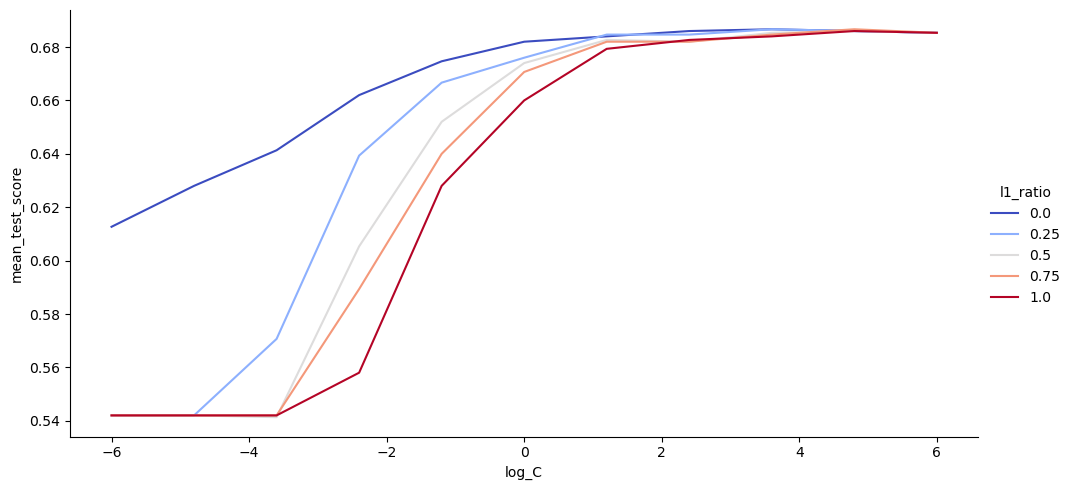

In [109]:
sns.relplot(data=mod3_cv_summary, x='log_C', y='mean_test_score', hue='l1_ratio',
           kind='line', palette='coolwarm', aspect=2)

plt.show()

**Extracting and adding the best model to a dataframe**

In [110]:
mod3_best_result = mod3_cv_summary.\
loc[mod3_cv_summary.mean_test_score == mod3_cv_summary.mean_test_score.max(), :].copy()

In [111]:
mod3_best_result['model_name'] = 'Mod-3: 2022 data'

In [112]:
mod3_best_result = mod3_best_result.\
loc[mod3_best_result.mean_test_score_se == mod3_best_result.mean_test_score_se.min(), :].copy()

In [113]:
mod3_best_result

,C,l1_ratio,mean_test_score,std_test_score,mean_test_score_se,log_C,model_name
40,36.598234,0.0,0.686667,0.052747,0.013619,3.6,Mod-3: 2022 data


### Model - 4
**Using all 2020, 2021, 2022 data and output as April-1 2023 (3 months from Dec 2022)**

In [114]:
mod4_days = ['day_' + str(d).zfill(3) for d in range(1,756+1)]

In [115]:
mod4_df = df_use.loc[:, ['sector'] + mod4_days ].copy()

In [116]:
mod4_df['outcome'] = np.where( df_use.apr_rel_close > df_use.day_756, 'event', 'non-event')

In [117]:
mod4_df.outcome.value_counts(normalize=True)

event        0.542
non-event    0.458
Name: outcome, dtype: float64

In [118]:
mod4_inputs_df = mod4_df.loc[:, ['sector'] + mod4_days].copy()

In [119]:
mod4_output_df = mod4_df.loc[:, ['outcome']].copy()

In [120]:
mod4_ytrain = mod4_output_df.outcome.to_numpy().ravel()

In [121]:
mod4_num_transform = Pipeline(steps=[ ('std_input', StandardScaler()) ])

In [122]:
mod4_cat_input = mod4_inputs_df.select_dtypes('object').columns.to_list()

In [123]:
mod4_cat_transform = Pipeline(steps=[ ('dummy', OneHotEncoder(drop='first')) ])

In [124]:
mod4_prepo_transform = ColumnTransformer(transformers=[ ('num', mod4_num_transform, mod4_days),
                                                        ('cat', mod4_cat_transform, mod4_cat_input)])

In [125]:
mod4_wflow = Pipeline(steps=[ ('prepo', mod4_prepo_transform),
                              ('enet', enet_to_fit)])

In [126]:
mod4_enet_search = GridSearchCV(mod4_wflow, enet_grid, cv=my_cv)

In [127]:
# mod4_t0 = time.time()

# mod4_enet_search_result = mod4_enet_search.fit(mod4_inputs_df, mod4_ytrain)

# mod4_t1 = time.time()

In [128]:
# (mod4_t1 - mod4_t0) / 60

**Save Model**

In [129]:
# pickle.dump(mod4_enet_search_result, open('mod4_final.sav', 'wb'))

**Load Model**

In [130]:
mod4_enet_search_result = pickle.load(open('mod4_final.sav', 'rb'))

In [131]:
mod4_enet_search_result.best_params_

{'enet__C': 1.0, 'enet__l1_ratio': 0.0}

In [132]:
mod4_enet_search_result.best_score_

0.7126666666666668

**Visualizing the result**

In [133]:
mod4_cv_summary = pd.DataFrame({'C': mod4_enet_search_result.cv_results_['param_enet__C'].data.astype('float64'),
                                'l1_ratio': mod4_enet_search_result.cv_results_['param_enet__l1_ratio'].data.astype('float64'),
                                'mean_test_score': mod4_enet_search_result.cv_results_['mean_test_score'],
                                'std_test_score': mod4_enet_search_result.cv_results_['std_test_score']})

In [134]:
mod4_cv_summary['mean_test_score_se'] = mod4_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [135]:
mod4_cv_summary['log_C'] = np.log( mod4_cv_summary.C )

In [136]:
mod4_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,C,l1_ratio,mean_test_score,std_test_score,mean_test_score_se,log_C
31,3.320117,0.25,0.712667,0.047535,0.012273,1.2
25,1.000000,0.00,0.712667,0.046111,0.011906,0.0
33,3.320117,0.75,0.712000,0.044151,0.011400,1.2
39,11.023176,1.00,0.711333,0.047870,0.012360,2.4
32,3.320117,0.50,0.710667,0.049862,0.012874,1.2


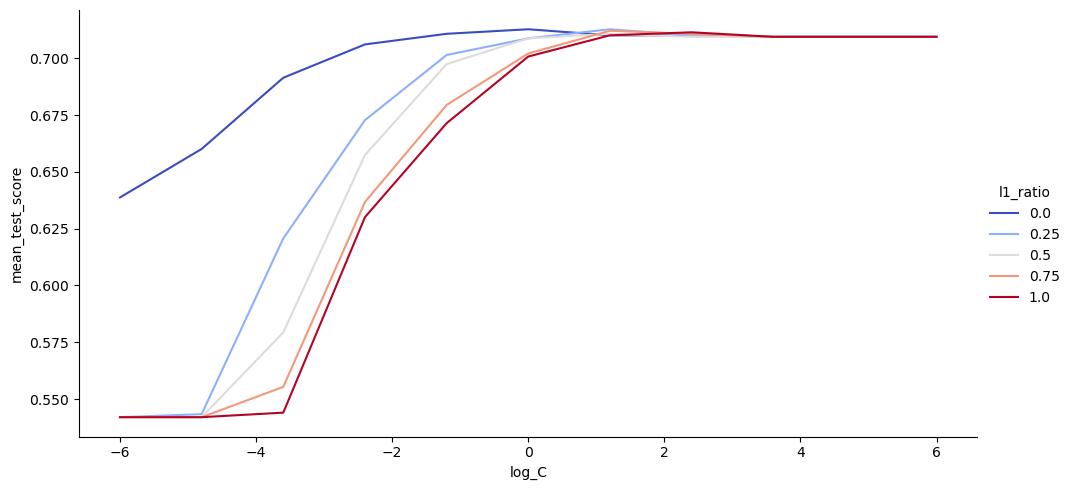

In [137]:
sns.relplot(data=mod4_cv_summary, x='log_C', y='mean_test_score', hue='l1_ratio',
           kind='line', palette='coolwarm', aspect=2)

plt.show()

**Extracting and adding the best model to dataframe**

In [138]:
mod4_best_result = mod4_cv_summary.\
loc[mod4_cv_summary.mean_test_score == mod4_cv_summary.mean_test_score.max(), :].copy()

In [139]:
mod4_best_result['model_name'] = 'Mod-4: All data'

In [140]:
mod4_best_result = mod4_best_result.\
loc[mod4_best_result.mean_test_score_se == mod4_best_result.mean_test_score_se.min(), :].copy()

In [141]:
mod4_best_result

,C,l1_ratio,mean_test_score,std_test_score,mean_test_score_se,log_C,model_name
25,1.0,0.0,0.712667,0.046111,0.011906,0.0,Mod-4: All data


### Model - 5
**Using 2020 data and output as April-1 2021 (3 months from Dec 2020) with PCA**

In [142]:
lasso_to_fit = LogisticRegression(penalty='l1', solver='saga', random_state=101, max_iter=100001)

In [143]:
pca_grid = {'prepo__num__pca__n_components': [30, 40, 50, 60, 70, 80, 90],
            'lasso__C': np.exp(np.linspace(-6, 6, 11))}

In [144]:
mod5_days = ['day_' + str(d).zfill(3) for d in range(1,252+1)]

In [145]:
mod5_df = df_use.loc[:, ['sector'] + mod5_days ].copy()

In [146]:
mod5_df['outcome'] = np.where( df_use.day_568 > df_use.day_504, 'event', 'non-event')

In [147]:
mod5_df.outcome.value_counts(normalize=True)

non-event    0.592
event        0.408
Name: outcome, dtype: float64

In [148]:
mod5_inputs_df = mod5_df.loc[:, ['sector'] + mod5_days].copy()

In [149]:
mod5_output_df = mod5_df.loc[:, ['outcome']].copy()

In [150]:
mod5_ytrain = mod5_output_df.outcome.to_numpy().ravel()

In [151]:
mod5_num_transform = Pipeline( steps=[ ('std_input', StandardScaler()),
                                       ('pca', PCA())])

In [152]:
mod5_cat_input = mod5_inputs_df.select_dtypes('object').columns.to_list()

In [153]:
mod5_cat_transform = Pipeline(steps= [('dummy', OneHotEncoder(drop='first')) ])

In [154]:
mod5_prepo_transform = ColumnTransformer(transformers=[ ('num', mod5_num_transform, mod5_days),
                                                        ('cat', mod5_cat_transform, mod5_cat_input)])

In [155]:
mod5_wflow = Pipeline(steps=[ ('prepo', mod5_prepo_transform),
                              ('lasso', lasso_to_fit) ])

In [156]:
mod5_pca_search = GridSearchCV(mod5_wflow, pca_grid, cv=my_cv)

In [157]:
# mod5_t0 = time.time()

# mod5_pca_search_result = mod5_pca_search.fit(mod5_inputs_df, mod5_ytrain)

# mod5_t1 = time.time()

In [158]:
# (mod5_t1 - mod5_t0) / 60

**Save Model**

In [159]:
# pickle.dump(mod5_pca_search_result, open('mod5_final.sav', 'wb'))

**Load Model**

In [160]:
mod5_pca_search_result = pickle.load(open('mod5_final.sav', 'rb'))

In [161]:
mod5_pca_search_result.best_params_

{'lasso__C': 3.320116922736545, 'prepo__num__pca__n_components': 80}

In [162]:
mod5_pca_search_result.best_score_

0.7453333333333333

**Visualizing the result**

In [163]:
mod5_cv_summary = pd.DataFrame({'C': mod5_pca_search_result.cv_results_['param_lasso__C'].data.astype('float64'),
                                'n_components': mod5_pca_search_result.cv_results_['param_prepo__num__pca__n_components'].data.astype('float64'),
                                'mean_test_score': mod5_pca_search_result.cv_results_['mean_test_score'],
                                'std_test_score': mod5_pca_search_result.cv_results_['std_test_score'] })

In [164]:
mod5_cv_summary['mean_test_score_se'] = mod5_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [165]:
mod5_cv_summary['log_C'] = np.log( mod5_cv_summary.C )

In [166]:
mod5_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,C,n_components,mean_test_score,std_test_score,mean_test_score_se,log_C
47,3.320117,80.0,0.745333,0.029635,0.007652,1.2
44,3.320117,50.0,0.743333,0.030258,0.007813,1.2
45,3.320117,60.0,0.743333,0.032592,0.008415,1.2
48,3.320117,90.0,0.740667,0.032139,0.008298,1.2
59,36.598234,60.0,0.740667,0.036234,0.009356,3.6


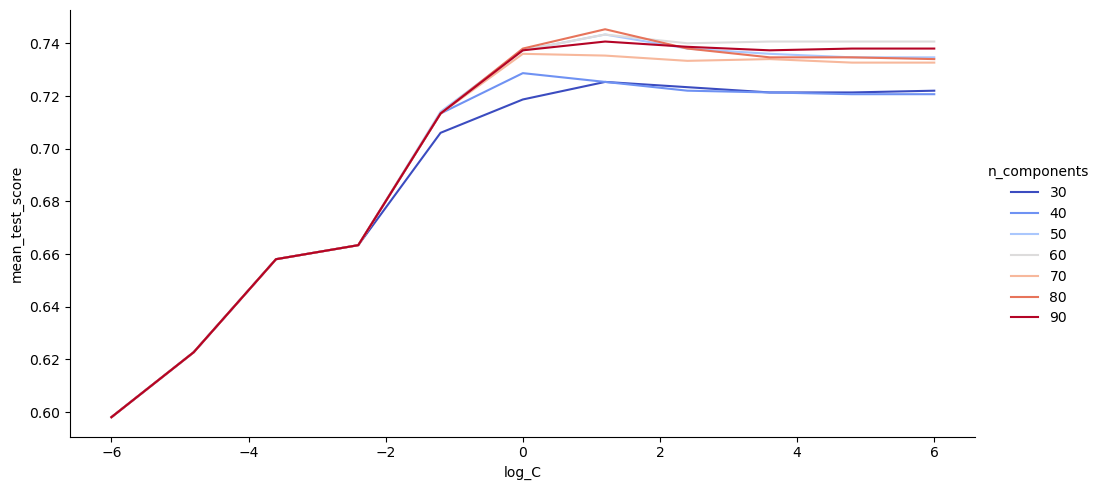

In [167]:
sns.relplot(data=mod5_cv_summary, x='log_C', y='mean_test_score', hue='n_components',
           kind='line', palette='coolwarm', aspect=2)

plt.show()

**Extracting and adding the best model to a data frame**

In [168]:
mod5_best_result = mod5_cv_summary.\
loc[mod5_cv_summary.mean_test_score == mod5_cv_summary.mean_test_score.max(), :].copy()

In [169]:
mod5_best_result['model_name'] = 'Mod-5: 2020 with PCA'

In [170]:
mod5_best_result

,C,n_components,mean_test_score,std_test_score,mean_test_score_se,log_C,model_name
47,3.320117,80.0,0.745333,0.029635,0.007652,1.2,Mod-5: 2020 with PCA


### Model - 6
**Using 2021 data and output as April-1 2022 (3 months from Dec 2021) with PCA**

In [171]:
mod6_days = ['day_' + str(d).zfill(3) for d in range(253,504+1)]

In [172]:
mod6_df = df_use.loc[:, ['sector'] + mod6_days ].copy()

In [173]:
mod6_df['outcome'] = np.where( df_use.day_568 > df_use.day_504, 'event', 'non-event')

In [174]:
mod6_df.outcome.value_counts(normalize=True)

non-event    0.592
event        0.408
Name: outcome, dtype: float64

In [175]:
mod6_inputs_df = mod6_df.loc[:, ['sector'] + mod6_days].copy()

In [176]:
mod6_output_df = mod6_df.loc[:, ['outcome']].copy()

In [177]:
mod6_ytrain = mod6_output_df.outcome.to_numpy().ravel()

In [178]:
mod6_num_transform = Pipeline( steps=[ ('std_input', StandardScaler()),
                                       ('pca', PCA())])

In [179]:
mod6_cat_input = mod6_inputs_df.select_dtypes('object').columns.to_list()

In [180]:
mod6_cat_transform = Pipeline(steps= [('dummy', OneHotEncoder(drop='first')) ])

In [181]:
mod6_prepo_transform = ColumnTransformer(transformers=[ ('num', mod6_num_transform, mod6_days),
                                                        ('cat', mod6_cat_transform, mod6_cat_input)])

In [182]:
mod6_wflow = Pipeline(steps=[ ('prepo', mod6_prepo_transform),
                              ('lasso', lasso_to_fit) ])

In [183]:
mod6_pca_search = GridSearchCV(mod6_wflow, pca_grid, cv=my_cv)

In [184]:
# mod6_t0 = time.time()

# mod6_pca_search_result = mod6_pca_search.fit(mod6_inputs_df, mod6_ytrain)

# mod6_t1 = time.time()

In [185]:
# (mod6_t1 - mod6_t0) / 60

**Save Model**

In [186]:
# pickle.dump(mod6_pca_search_result, open('mod6_final.sav', 'wb'))

**Load Model**

In [187]:
mod6_pca_search_result = pickle.load(open('mod6_final.sav', 'rb'))

In [188]:
mod6_pca_search_result.best_params_

{'lasso__C': 11.023176380641605, 'prepo__num__pca__n_components': 80}

In [189]:
mod6_pca_search_result.best_score_

0.724

**Visualzing the result**

In [190]:
mod6_cv_summary = pd.DataFrame({'C': mod6_pca_search_result.cv_results_['param_lasso__C'].data.astype('float64'),
                                'n_components': mod6_pca_search_result.cv_results_['param_prepo__num__pca__n_components'].data.astype('float64'),
                                'mean_test_score': mod6_pca_search_result.cv_results_['mean_test_score'],
                                'std_test_score': mod6_pca_search_result.cv_results_['std_test_score'] })

In [191]:
mod6_cv_summary['mean_test_score_se'] = mod6_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [192]:
mod6_cv_summary['log_C'] = np.log( mod6_cv_summary.C )

In [193]:
mod6_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,C,n_components,mean_test_score,std_test_score,mean_test_score_se,log_C
54,11.023176,80.0,0.724000,0.039799,0.010276,2.4
55,11.023176,90.0,0.724000,0.039799,0.010276,2.4
68,121.510418,80.0,0.723333,0.039609,0.010227,4.8
75,403.428793,80.0,0.723333,0.039609,0.010227,6.0
53,11.023176,70.0,0.723333,0.040607,0.010485,2.4


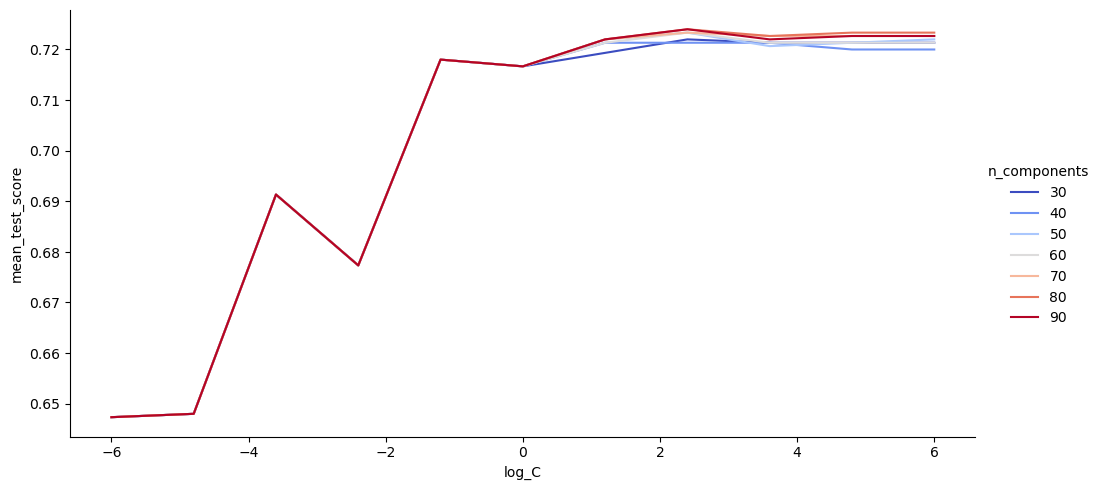

In [194]:
sns.relplot(data=mod6_cv_summary, x='log_C', y='mean_test_score', hue='n_components',
           kind='line', palette='coolwarm', aspect=2)

plt.show()

**Extracting and adding the best model to dataframe**

In [195]:
mod6_best_result = mod6_cv_summary.\
loc[mod6_cv_summary.mean_test_score == mod6_cv_summary.mean_test_score.max(), :].copy()

In [196]:
mod6_best_result['model_name'] = 'Mod-6: 2021 with PCA'

In [197]:
mod6_best_result = mod6_best_result.\
loc[mod6_best_result.n_components == mod6_best_result.n_components.min(), :].copy()

In [198]:
mod6_best_result

,C,n_components,mean_test_score,std_test_score,mean_test_score_se,log_C,model_name
54,11.023176,80.0,0.724,0.039799,0.010276,2.4,Mod-6: 2021 with PCA


### Model - 7
**Using 2022 data and output as April-1 2023 (3 months from Dec 2022) with PCA**

In [199]:
mod7_days = ['day_' + str(d).zfill(3) for d in range(505,756+1)]

In [200]:
mod7_df = df_use.loc[:, ['sector'] + mod7_days ].copy()

In [201]:
mod7_df['outcome'] = np.where( df_use.apr_rel_close > df_use.day_756, 'event', 'non-event')

In [202]:
mod7_df.outcome.value_counts(normalize=True)

event        0.542
non-event    0.458
Name: outcome, dtype: float64

In [203]:
mod7_inputs_df = mod7_df.loc[:, ['sector'] + mod7_days].copy()

In [204]:
mod7_output_df = mod7_df.loc[:, ['outcome']].copy()

In [205]:
mod7_ytrain = mod7_output_df.outcome.to_numpy().ravel()

In [206]:
mod7_num_transform = Pipeline( steps=[ ('std_input', StandardScaler()),
                                       ('pca', PCA())])

In [207]:
mod7_cat_input = mod7_inputs_df.select_dtypes('object').columns.to_list()

In [208]:
mod7_cat_transform = Pipeline(steps= [('dummy', OneHotEncoder(drop='first')) ])

In [209]:
mod7_prepo_transform = ColumnTransformer(transformers=[ ('num', mod7_num_transform, mod7_days),
                                                        ('cat', mod7_cat_transform, mod7_cat_input)])

In [210]:
mod7_wflow = Pipeline(steps=[ ('prepo', mod7_prepo_transform),
                              ('lasso', lasso_to_fit) ])

In [211]:
mod7_pca_search = GridSearchCV(mod7_wflow, pca_grid, cv=my_cv)

In [212]:
# mod7_t0 = time.time()

# mod7_pca_search_result = mod7_pca_search.fit(mod7_inputs_df, mod7_ytrain)

# mod7_t1 = time.time()

In [213]:
# (mod7_t1 - mod7_t0) / 60

**Save Model**

In [214]:
# pickle.dump(mod7_pca_search_result, open('mod7_final.sav', 'wb'))

**Load Model**

In [215]:
mod7_pca_search_result = pickle.load(open('mod7_final.sav', 'rb'))

In [216]:
mod7_pca_search_result.best_params_

{'lasso__C': 121.51041751873476, 'prepo__num__pca__n_components': 80}

In [217]:
mod7_pca_search_result.best_score_

0.6973333333333334

**Visualizing the result**

In [218]:
mod7_cv_summary = pd.DataFrame({'C': mod7_pca_search_result.cv_results_['param_lasso__C'].data.astype('float64'),
                                'n_components': mod7_pca_search_result.cv_results_['param_prepo__num__pca__n_components'].data.astype('float64'),
                                'mean_test_score': mod7_pca_search_result.cv_results_['mean_test_score'],
                                'std_test_score': mod7_pca_search_result.cv_results_['std_test_score'] })

In [219]:
mod7_cv_summary['mean_test_score_se'] = mod7_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [220]:
mod7_cv_summary['log_C'] = np.log( mod7_cv_summary.C )

In [221]:
mod7_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,C,n_components,mean_test_score,std_test_score,mean_test_score_se,log_C
68,121.510418,80.0,0.697333,0.047814,0.012346,4.8
75,403.428793,80.0,0.697333,0.047814,0.012346,6.0
76,403.428793,90.0,0.696667,0.048397,0.012496,6.0
66,121.510418,60.0,0.696667,0.047703,0.012317,4.8
69,121.510418,90.0,0.696667,0.048397,0.012496,4.8


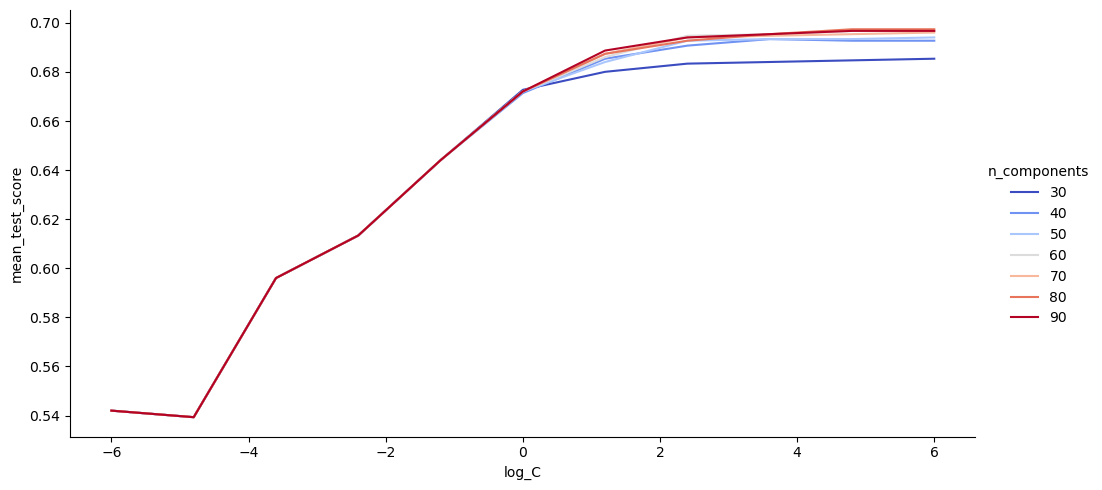

In [222]:
sns.relplot(data=mod7_cv_summary, x='log_C', y='mean_test_score', hue='n_components',
           kind='line', palette='coolwarm', aspect=2)

plt.show()

**Extracting and adding the best model to a dataframe**

In [223]:
mod7_best_result = mod7_cv_summary.\
loc[mod7_cv_summary.mean_test_score == mod7_cv_summary.mean_test_score.max(), :].copy()

In [224]:
mod7_best_result['model_name'] = 'Mod-7: 2022 with PCA'

In [225]:
mod7_best_result = mod7_best_result.\
loc[mod7_best_result.log_C == mod7_best_result.log_C.min(), :].copy()

In [226]:
mod7_best_result

,C,n_components,mean_test_score,std_test_score,mean_test_score_se,log_C,model_name
68,121.510418,80.0,0.697333,0.047814,0.012346,4.8,Mod-7: 2022 with PCA


### Model - 8
**Using all 2020, 2021, 2022 data and output as April-1 2023 (3 months from Dec 2022) with PCA**

In [227]:
mod8_days = ['day_' + str(d).zfill(3) for d in range(1,756+1)]

In [228]:
mod8_df = df_use.loc[:, ['sector'] + mod8_days ].copy()

In [229]:
mod8_df['outcome'] = np.where( df_use.apr_rel_close > df_use.day_756, 'event', 'non-event')

In [230]:
mod8_df.outcome.value_counts(normalize=True)

event        0.542
non-event    0.458
Name: outcome, dtype: float64

In [231]:
mod8_inputs_df = mod8_df.loc[:, ['sector'] + mod8_days].copy()

In [232]:
mod8_output_df = mod8_df.loc[:, ['outcome']].copy()

In [233]:
mod8_ytrain = mod8_output_df.outcome.to_numpy().ravel()

In [234]:
mod8_num_transform = Pipeline( steps=[ ('std_input', StandardScaler()),
                                       ('pca', PCA())])

In [235]:
mod8_cat_input = mod8_inputs_df.select_dtypes('object').columns.to_list()

In [236]:
mod8_cat_transform = Pipeline(steps= [('dummy', OneHotEncoder(drop='first')) ])

In [237]:
mod8_prepo_transform = ColumnTransformer(transformers=[ ('num', mod8_num_transform, mod8_days),
                                                        ('cat', mod8_cat_transform, mod8_cat_input)])

In [238]:
mod8_wflow = Pipeline(steps=[ ('prepo', mod8_prepo_transform),
                              ('lasso', lasso_to_fit) ])

In [239]:
mod8_pca_grid = {'prepo__num__pca__n_components': [60, 70, 80, 90, 100, 115, 130, 150],
                 'lasso__C': np.exp(np.linspace(-6, 6, 11))}

In [240]:
mod8_pca_search = GridSearchCV(mod8_wflow, mod8_pca_grid, cv=my_cv)

In [241]:
# mod8_t0 = time.time()

# mod8_pca_search_result = mod8_pca_search.fit(mod8_inputs_df, mod8_ytrain)

# mod8_t1 = time.time()

In [242]:
# (mod8_t1 - mod8_t0 ) / 60

**Save Model**

In [243]:
# pickle.dump(mod8_pca_search_result, open('mod8_final.sav', 'wb'))

**Load Model**

In [244]:
mod8_pca_search_result = pickle.load(open('mod8_final.sav', 'rb'))

In [245]:
mod8_pca_search_result.best_params_

{'lasso__C': 36.598234443677974, 'prepo__num__pca__n_components': 115}

In [246]:
mod8_pca_search_result.best_score_

0.7133333333333334

**Visualizing the result**

In [247]:
mod8_cv_summary = pd.DataFrame({'C': mod8_pca_search_result.cv_results_['param_lasso__C'].data.astype('float64'),
                                'n_components': mod8_pca_search_result.cv_results_['param_prepo__num__pca__n_components'].data.astype('float64'),
                                'mean_test_score': mod8_pca_search_result.cv_results_['mean_test_score'],
                                'std_test_score': mod8_pca_search_result.cv_results_['std_test_score'] })

In [248]:
mod8_cv_summary['mean_test_score_se'] = mod8_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [249]:
mod8_cv_summary['log_C'] = np.log( mod8_cv_summary.C )

In [250]:
mod8_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,C,n_components,mean_test_score,std_test_score,mean_test_score_se,log_C
83,403.428793,90.0,0.713333,0.049216,0.012708,6.0
69,36.598234,115.0,0.713333,0.046571,0.012025,3.6
87,403.428793,150.0,0.712667,0.048231,0.012453,6.0
75,121.510418,90.0,0.712667,0.049189,0.012701,4.8
77,121.510418,115.0,0.712667,0.046399,0.011980,4.8


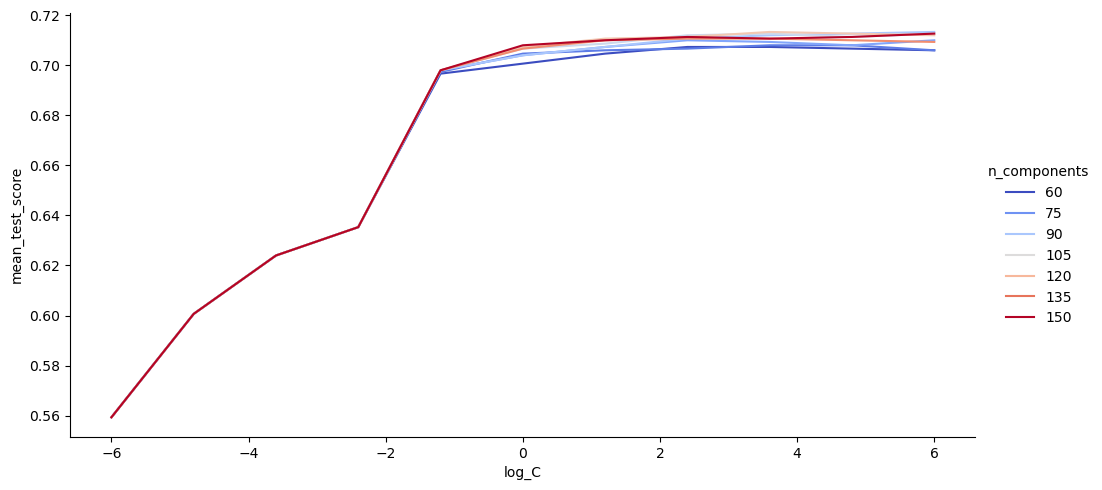

In [251]:
sns.relplot(data=mod8_cv_summary, x='log_C', y='mean_test_score', hue='n_components',
           kind='line', palette='coolwarm', aspect=2)

plt.show()

**Extracting and adding the best model to a dataframe**

In [252]:
mod8_best_result = mod8_cv_summary.\
loc[mod8_cv_summary.mean_test_score == mod8_cv_summary.mean_test_score.max(), :].copy()

In [253]:
mod8_best_result['model_name'] = 'Mod-8: All data with PCA'

In [254]:
mod8_best_result = mod8_best_result.\
loc[mod8_best_result.n_components == mod8_best_result.n_components.min(), :].copy()

In [255]:
mod8_best_result

,C,n_components,mean_test_score,std_test_score,mean_test_score_se,log_C,model_name
83,403.428793,90.0,0.713333,0.049216,0.012708,6.0,Mod-8: All data with PCA


### Model - 9 
**Using all 3 year data with seasonal data**

In [256]:
mod9_days = ['day_' + str(d).zfill(3) for d in range(1,756+1)]

In [257]:
mod9_seasonal = ['seasonal_week_' + str(d).zfill(3) for d in range(1,157+1)]

In [258]:
mod9_df = df_use.loc[:, ['sector'] + mod9_days + mod9_seasonal].copy()

In [259]:
mod9_df['outcome'] = np.where( df_use.apr_rel_close > df_use.day_756, 'event', 'non-event')

In [260]:
mod9_df.outcome.value_counts(normalize=True)

event        0.542
non-event    0.458
Name: outcome, dtype: float64

In [261]:
mod9_inputs_df = mod9_df.loc[:, ['sector'] + mod9_days + mod9_seasonal].copy()

In [262]:
mod9_output_df = mod9_df.loc[:, ['outcome']].copy()

In [263]:
mod9_ytrain = mod9_output_df.outcome.to_numpy().ravel()

In [264]:
mod9_num_transform = Pipeline(steps=[ ('std_input', StandardScaler()),
                                      ('pca_input', PCA()) ])

In [265]:
mod9_ses_transform = Pipeline(steps=[ ('std_ses', StandardScaler()),
                                      ('pca_ses', PCA()) ])

In [266]:
mod9_num_ses_transform = ColumnTransformer(transformers=[ ('num', mod9_num_transform, mod9_days),
                                                          ('ses', mod9_ses_transform, mod9_seasonal) ])

In [267]:
mod9_num_ses_final_transform = Pipeline(steps=[ ('num_ses', mod9_num_ses_transform),
                                                ('std_num_ses', StandardScaler())])

In [268]:
mod9_cat_input = mod9_inputs_df.select_dtypes('object').columns.to_list()

In [269]:
mod9_cat_transform = Pipeline(steps= [('dummy', OneHotEncoder(drop='first')) ])

In [270]:
mod9_prepo_transform = ColumnTransformer(transformers=[ ('all', mod9_num_ses_final_transform, mod9_days+mod9_seasonal),
                                                        ('cat', mod9_cat_transform, mod9_cat_input) ])

In [271]:
mod9_wflow = Pipeline(steps=[ ('prepo', mod9_prepo_transform),
                              ('lasso', lasso_to_fit) ])

In [272]:
mod9_pca_grid = {'prepo__all__num_ses__num__pca_input__n_components': [30, 100, 150],
                 'prepo__all__num_ses__ses__pca_ses__n_components': [10, 40, 70],
                 'lasso__C': np.exp(np.linspace(-6, 6, 11)) }

In [273]:
mod9_pca_search = GridSearchCV(mod9_wflow, mod9_pca_grid, cv=my_cv)

In [274]:
# mod9_t0 = time.time()

# mod9_pca_search_result = mod9_pca_search.fit(mod9_inputs_df, mod9_ytrain)

# mod9_t1 = time.time()

In [275]:
# (mod9_t1 - mod9_t0) / 60

**Save Model**

In [276]:
# pickle.dump(mod9_pca_search_result, open('mod9_final.sav', 'wb'))

**Load Model**

In [277]:
mod9_pca_search_result = pickle.load(open('mod9_final.sav', 'rb'))

In [278]:
mod9_pca_search_result.best_params_

{'lasso__C': 0.301194211912202,
 'prepo__all__num_ses__num__pca_input__n_components': 100,
 'prepo__all__num_ses__ses__pca_ses__n_components': 70}

In [279]:
mod9_pca_search_result.best_score_

0.7119999999999999

**Visualizing the result**

In [280]:
mod9_cv_summary = pd.DataFrame({'C': mod9_pca_search_result.cv_results_['param_lasso__C'].data.astype('float64'),
                                'data_n_components': mod9_pca_search_result.cv_results_['param_prepo__all__num_ses__num__pca_input__n_components'].data.astype('float64'),
                                'ses_n_components': mod9_pca_search_result.cv_results_['param_prepo__all__num_ses__ses__pca_ses__n_components'].data.astype('float64'),
                                'mean_test_score': mod9_pca_search_result.cv_results_['mean_test_score'],
                                'std_test_score': mod9_pca_search_result.cv_results_['std_test_score'] })

In [281]:
mod9_cv_summary['mean_test_score_se'] = mod9_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [282]:
mod9_cv_summary['log_C'] = np.log( mod9_cv_summary.C )

In [283]:
mod9_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,C,data_n_components,ses_n_components,mean_test_score,std_test_score,mean_test_score_se,log_C
41,0.301194,100.0,70.0,0.712000,0.040694,0.010507,-1.2
56,3.320117,30.0,70.0,0.711333,0.037571,0.009701,1.2
44,0.301194,150.0,70.0,0.710000,0.045314,0.011700,-1.2
47,1.000000,30.0,70.0,0.709333,0.037142,0.009590,0.0
74,36.598234,30.0,70.0,0.708000,0.047357,0.012227,3.6


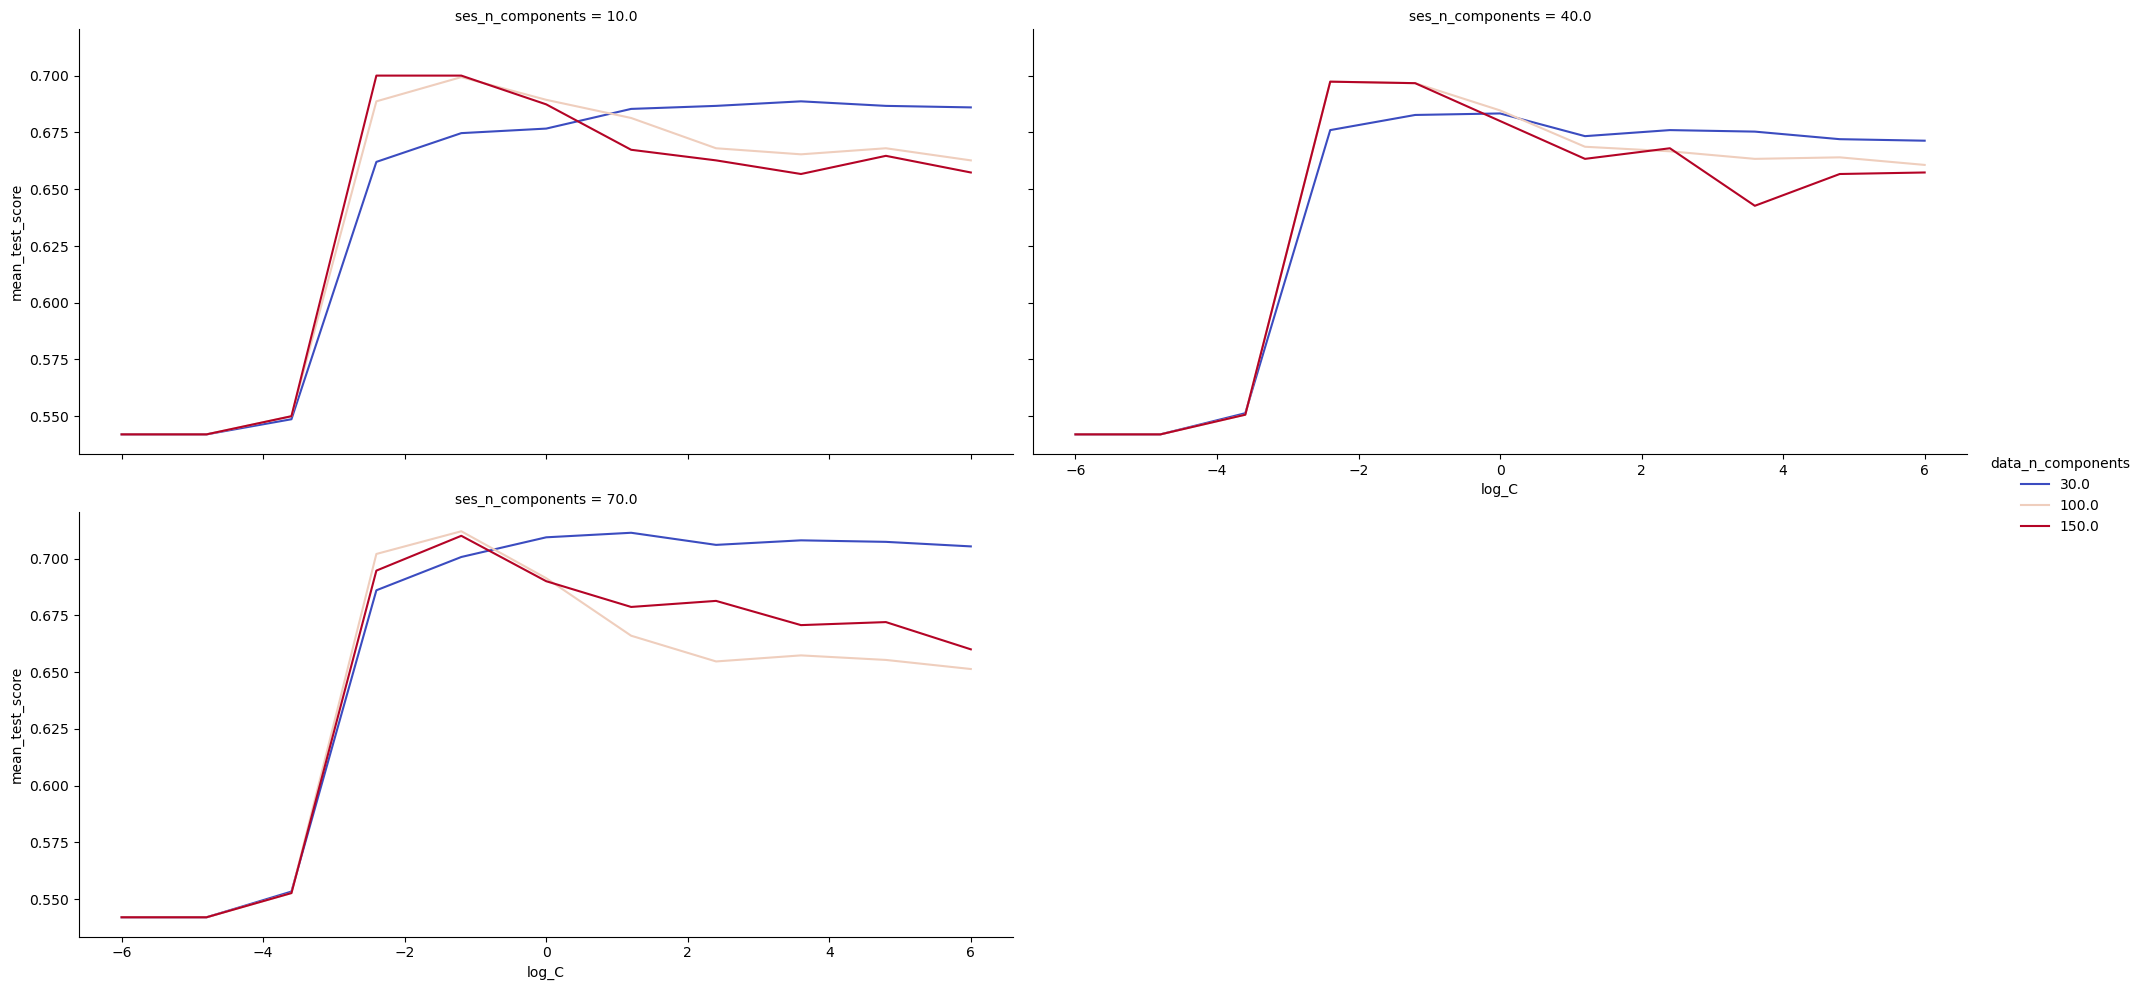

In [284]:
sns.relplot(data=mod9_cv_summary, x='log_C', y='mean_test_score', hue='data_n_components',
            col='ses_n_components', col_wrap=2,
           kind='line', palette='coolwarm', aspect=2)

plt.show()

**Extracting and adding the best model to a dataframe**

In [285]:
mod9_best_result = mod9_cv_summary.\
loc[mod9_cv_summary.mean_test_score == mod9_cv_summary.mean_test_score.max(), :].copy()

In [286]:
mod9_best_result['model_name'] = 'Mod-9: All + ses data with PCA'

In [287]:
mod9_best_result

,C,data_n_components,ses_n_components,mean_test_score,std_test_score,mean_test_score_se,log_C,model_name
41,0.301194,100.0,70.0,0.712,0.040694,0.010507,-1.2,Mod-9: All + ses data with PCA


### Model - 10 
**Using all 3 year data with trend data**

In [288]:
mod10_days = ['day_' + str(d).zfill(3) for d in range(1,756+1)]

In [289]:
mod10_trend = ['trend_week_' + str(d).zfill(3) for d in range(1,157+1)]

In [290]:
mod10_df = df_use.loc[:, ['sector'] + mod10_days + mod10_trend].copy()

In [291]:
mod10_df['outcome'] = np.where( df_use.apr_rel_close > df_use.day_756, 'event', 'non-event')

In [292]:
mod10_df.outcome.value_counts(normalize=True)

event        0.542
non-event    0.458
Name: outcome, dtype: float64

In [293]:
mod10_inputs_df = mod10_df.loc[:, ['sector'] + mod10_days + mod10_trend].copy()

In [294]:
mod10_output_df = mod10_df.loc[:, ['outcome']].copy()

In [295]:
mod10_ytrain = mod10_output_df.outcome.to_numpy().ravel()

In [296]:
mod10_num_transform = Pipeline(steps=[ ('std_input', StandardScaler()),
                                       ('pca_input', PCA()) ])

In [297]:
mod10_trend_transform = Pipeline(steps=[ ('std_trend', StandardScaler()),
                                         ('pca_trend', PCA()) ])

In [298]:
mod10_num_trend_transform = ColumnTransformer(transformers=[ ('num', mod10_num_transform, mod10_days),
                                                             ('trend', mod10_trend_transform, mod10_trend) ])  

In [299]:
mod10_num_trend_final_transform = Pipeline(steps=[ ('num_trend', mod10_num_trend_transform),
                                                   ('std_num_trend', StandardScaler())])

In [300]:
mod10_cat_input = mod10_inputs_df.select_dtypes('object').columns.to_list()

In [301]:
mod10_cat_transform = Pipeline(steps= [('dummy', OneHotEncoder(drop='first')) ])

In [302]:
mod10_prepo_transform = ColumnTransformer(transformers=[ ('all', mod10_num_trend_final_transform, mod10_days+mod10_trend),
                                                         ('cat', mod10_cat_transform, mod10_cat_input) ])

In [303]:
mod10_wflow = Pipeline(steps=[ ('prepo', mod10_prepo_transform),
                               ('lasso', lasso_to_fit) ])

In [304]:
mod10_pca_grid = {'prepo__all__num_trend__num__pca_input__n_components': [30, 100, 150],
                  'prepo__all__num_trend__trend__pca_trend__n_components': [10, 40, 70],
                  'lasso__C': np.exp(np.linspace(-6, 6, 11)) }

In [305]:
mod10_pca_search = GridSearchCV(mod10_wflow, mod10_pca_grid, cv=my_cv)

In [306]:
# mod10_t0 = time.time()

# mod10_pca_search_result = mod10_pca_search.fit(mod10_inputs_df, mod10_ytrain)

# mod10_t1 = time.time()

In [307]:
# (mod10_t1 - mod10_t0) / 60

**Save Model**

In [308]:
# pickle.dump(mod10_pca_search_result, open('mod10_final.sav', 'wb'))

**Load Model**

In [309]:
mod10_pca_search_result = pickle.load(open('mod10_final.sav', 'rb'))

In [310]:
mod10_pca_search_result.best_params_

{'lasso__C': 0.301194211912202,
 'prepo__all__num_trend__num__pca_input__n_components': 100,
 'prepo__all__num_trend__trend__pca_trend__n_components': 10}

In [311]:
mod10_pca_search_result.best_score_

0.7073333333333334

**Visualizing the result**

In [312]:
mod10_cv_summary = pd.DataFrame({'C': mod10_pca_search_result.cv_results_['param_lasso__C'].data.astype('float64'),
                                'data_n_components': mod10_pca_search_result.cv_results_['param_prepo__all__num_trend__num__pca_input__n_components'].data.astype('float64'),
                                'ses_n_components': mod10_pca_search_result.cv_results_['param_prepo__all__num_trend__trend__pca_trend__n_components'].data.astype('float64'),
                                'mean_test_score': mod10_pca_search_result.cv_results_['mean_test_score'],
                                'std_test_score': mod10_pca_search_result.cv_results_['std_test_score'] })

In [313]:
mod10_cv_summary['mean_test_score_se'] = mod10_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [314]:
mod10_cv_summary['log_C'] = np.log( mod10_cv_summary.C )

In [315]:
mod10_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,C,data_n_components,ses_n_components,mean_test_score,std_test_score,mean_test_score_se,log_C
39,0.301194,100.0,10.0,0.707333,0.041548,0.010728,-1.2
42,0.301194,150.0,10.0,0.704667,0.047731,0.012324,-1.2
33,0.090718,150.0,10.0,0.702667,0.055434,0.014313,-2.4
40,0.301194,100.0,40.0,0.700000,0.048442,0.012508,-1.2
30,0.090718,100.0,10.0,0.698667,0.046024,0.011883,-2.4


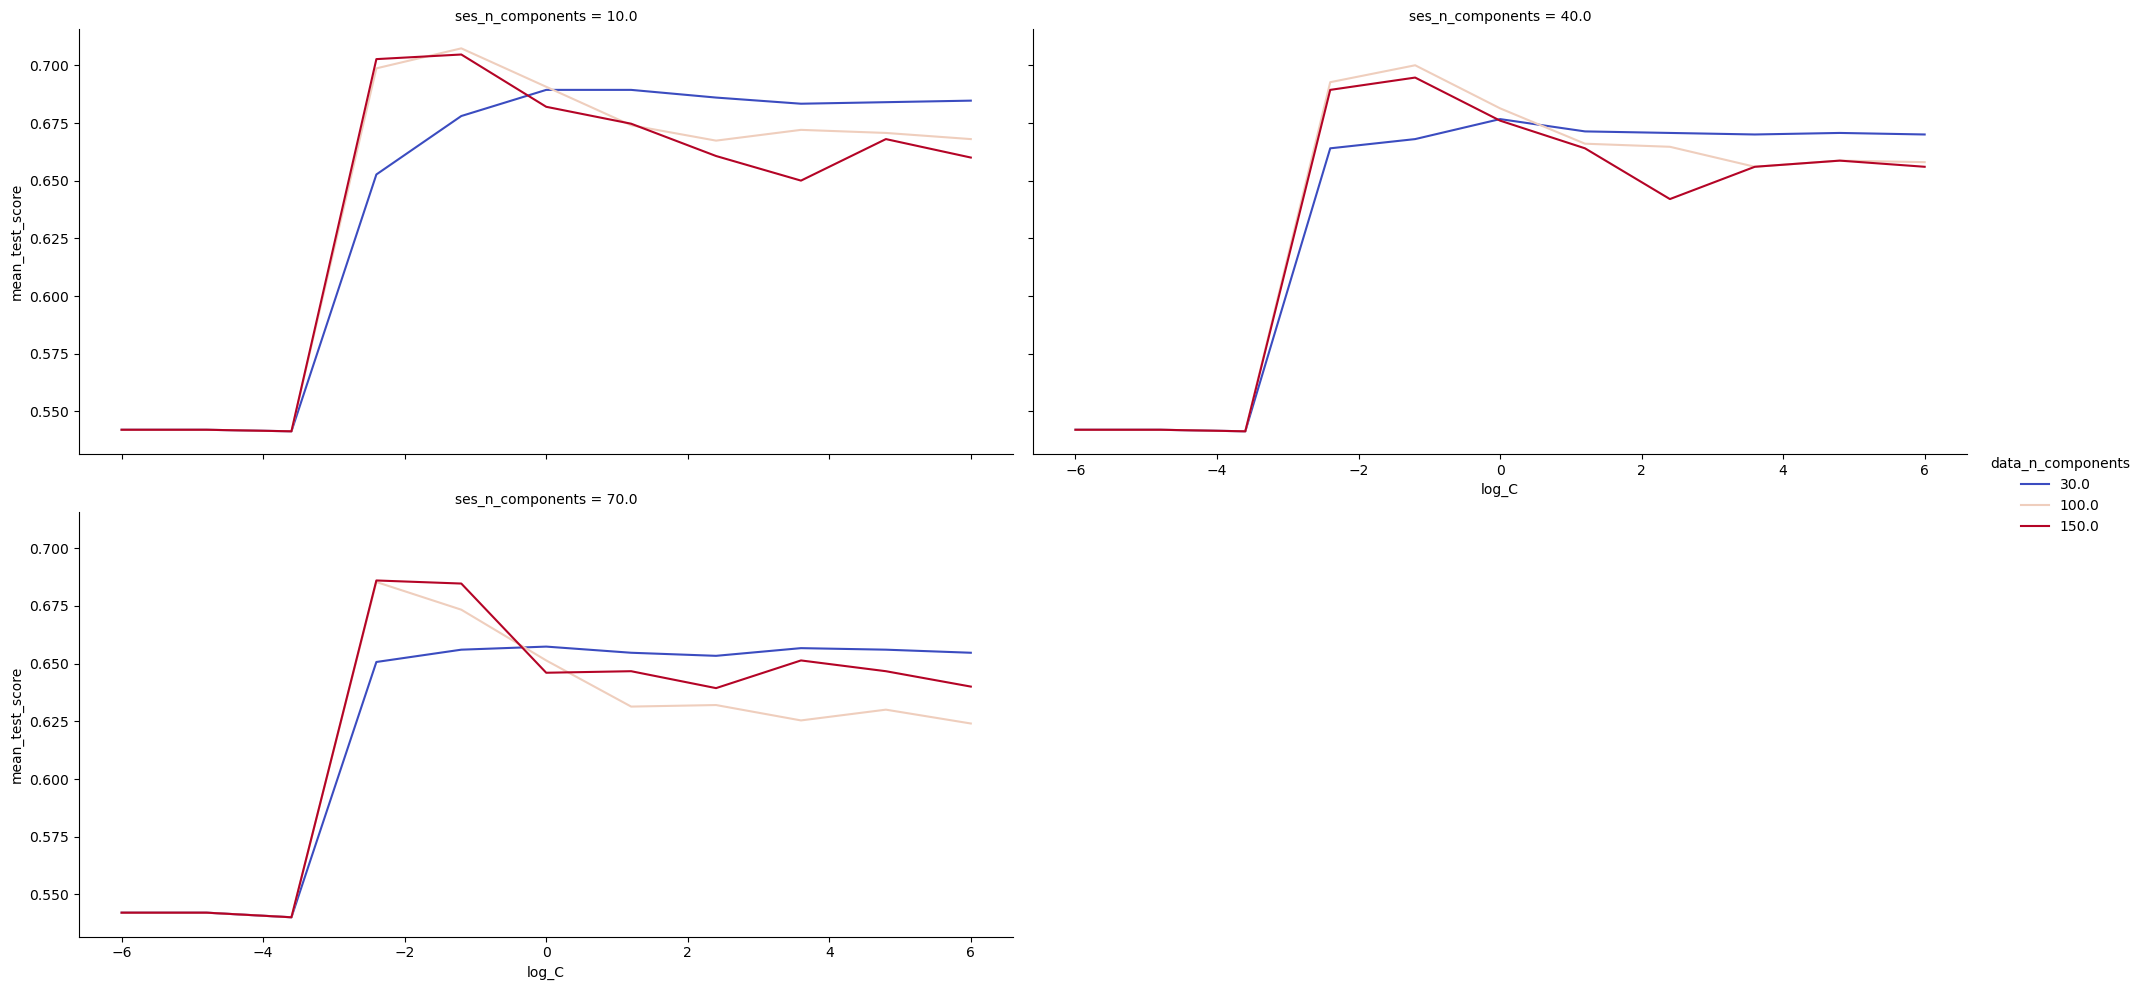

In [316]:
sns.relplot(data=mod10_cv_summary, x='log_C', y='mean_test_score', hue='data_n_components',
            col='ses_n_components', col_wrap=2,
           kind='line', palette='coolwarm', aspect=2)

plt.show()

**Extracting and adding the best model to a dataframe**

In [317]:
mod10_best_result = mod10_cv_summary.\
loc[mod10_cv_summary.mean_test_score == mod10_cv_summary.mean_test_score.max(), :].copy()

In [318]:
mod10_best_result['model_name'] = 'Mod-10: All + trend data with PCA'

In [319]:
mod10_best_result

,C,data_n_components,ses_n_components,mean_test_score,std_test_score,mean_test_score_se,log_C,model_name
39,0.301194,100.0,10.0,0.707333,0.041548,0.010728,-1.2,Mod-10: All + trend data with PCA


### Model - 11
**Using just seasonal data with PCA**

In [320]:
mod11_seasonal_days = ['seasonal_week_' + str(d).zfill(3) for d in range(1, 157+1)]

In [321]:
mod11_df = df_use.loc[:, ['sector'] + mod11_seasonal_days].copy()

In [322]:
mod11_df['outcome'] = np.where( df_use.apr_rel_close > df_use.day_756, 'event', 'non-event')

In [323]:
mod11_df.outcome.value_counts(normalize=True)

event        0.542
non-event    0.458
Name: outcome, dtype: float64

In [324]:
mod11_inputs_df = mod11_df.loc[:, ['sector'] + mod11_seasonal_days].copy()

In [325]:
mod11_output_df = mod11_df.loc[:, ['outcome']].copy()

In [326]:
mod11_ytrain = mod11_output_df.outcome.to_numpy().ravel()

In [327]:
mod11_ses_transform = Pipeline(steps=[ ('std_ses', StandardScaler()),
                                       ('pca_ses', PCA()) ])

In [328]:
mod11_cat_input = mod11_inputs_df.select_dtypes('object').columns.to_list()

In [329]:
mod11_cat_transform = Pipeline(steps= [('dummy', OneHotEncoder(drop='first')) ])

In [330]:
mod11_prepo_transform = ColumnTransformer(transformers=[ ('ses', mod11_ses_transform, mod11_seasonal_days),
                                                         ('cat', mod11_cat_transform, mod11_cat_input) ])

In [331]:
mod11_wflow = Pipeline(steps=[ ('prepo', mod11_prepo_transform),
                               ('lasso', lasso_to_fit) ])

In [332]:
mod11_pca_grid = {'prepo__ses__pca_ses__n_components': [3, 4, 5, 6, 7],
                  'lasso__C': np.exp(np.linspace(-6, 6, 11)) }

In [333]:
mod11_pca_search = GridSearchCV(mod11_wflow, mod11_pca_grid, cv=my_cv)

In [334]:
# mod11_t0 = time.time()

# mod11_pca_search_result = mod11_pca_search.fit(mod11_inputs_df, mod11_ytrain)

# mod11_t1 = time.time()

In [335]:
# (mod11_t1 - mod11_t0) / 60

**Save Model**

In [336]:
# pickle.dump(mod11_pca_search_result, open('mod11_final.sav', 'wb'))

**Load Model**

In [337]:
mod11_pca_search_result = pickle.load(open('mod11_final.sav', 'rb'))

In [338]:
mod11_pca_search_result.best_params_

{'lasso__C': 36.598234443677974, 'prepo__ses__pca_ses__n_components': 6}

In [339]:
mod11_pca_search_result.best_score_

0.6900000000000001

**Visualizing the result**

In [340]:
mod11_cv_summary = pd.DataFrame({'C': mod11_pca_search_result.cv_results_['param_lasso__C'].data.astype('float64'),
                                'ses_n_components': mod11_pca_search_result.cv_results_['param_prepo__ses__pca_ses__n_components'].data.astype('float64'),
                                'mean_test_score': mod11_pca_search_result.cv_results_['mean_test_score'],
                                'std_test_score': mod11_pca_search_result.cv_results_['std_test_score'] })

In [341]:
mod11_cv_summary['mean_test_score_se'] = mod11_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [342]:
mod11_cv_summary['log_C'] = np.log( mod11_cv_summary.C )

In [343]:
mod11_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,C,ses_n_components,mean_test_score,std_test_score,mean_test_score_se,log_C
43,36.598234,6.0,0.690000,0.042426,0.010954,3.6
53,403.428793,6.0,0.689333,0.041708,0.010769,6.0
52,403.428793,5.0,0.689333,0.046543,0.012017,6.0
48,121.510418,6.0,0.689333,0.041708,0.010769,4.8
38,11.023176,6.0,0.688667,0.041129,0.010619,2.4


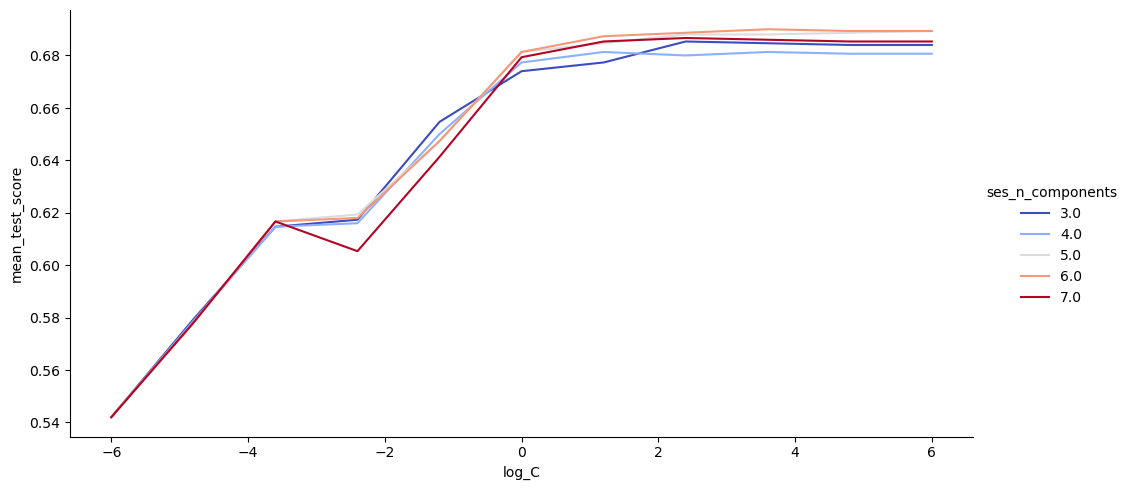

In [344]:
sns.relplot(data=mod11_cv_summary, x='log_C', y='mean_test_score', hue='ses_n_components',
           kind='line', palette='coolwarm', aspect=2)

plt.show()

**Extracting and adding the best model to a dataframe**

In [345]:
mod11_best_result = mod11_cv_summary.\
loc[mod11_cv_summary.mean_test_score == mod11_cv_summary.mean_test_score.max(), :].copy()

In [346]:
mod11_best_result['model_name'] = 'Mod-11: Ses data with PCA'

In [347]:
mod11_best_result

,C,ses_n_components,mean_test_score,std_test_score,mean_test_score_se,log_C,model_name
43,36.598234,6.0,0.69,0.042426,0.010954,3.6,Mod-11: Ses data with PCA


### Model - 12
**Using just trend data with PCA**

In [348]:
mod12_trend_days = ['trend_week_' + str(d).zfill(3) for d in range(1, 157+1)]

In [349]:
mod12_df = df_use.loc[:, ['sector'] + mod12_trend_days].copy()

In [350]:
mod12_df['outcome'] = np.where( df_use.apr_rel_close > df_use.day_756, 'event', 'non-event')

In [351]:
mod12_df.outcome.value_counts(normalize=True)

event        0.542
non-event    0.458
Name: outcome, dtype: float64

In [352]:
mod12_inputs_df = mod12_df.loc[:, ['sector'] + mod12_trend_days].copy()

In [353]:
mod12_output_df = mod12_df.loc[:, ['outcome']].copy()

In [354]:
mod12_ytrain = mod12_output_df.outcome.to_numpy().ravel()

In [355]:
mod12_trend_transform = Pipeline(steps=[ ('std_trend', StandardScaler()),
                                         ('pca_trend', PCA()) ])

In [356]:
mod12_cat_input = mod12_inputs_df.select_dtypes('object').columns.to_list()

In [357]:
mod12_cat_transform = Pipeline(steps= [('dummy', OneHotEncoder(drop='first')) ])

In [358]:
mod12_prepo_transform = ColumnTransformer(transformers=[ ('trend', mod12_trend_transform, mod12_trend_days),
                                                         ('cat', mod12_cat_transform, mod12_cat_input) ])

In [359]:
mod12_wflow = Pipeline(steps=[ ('prepo', mod12_prepo_transform),
                               ('lasso', lasso_to_fit) ])

In [360]:
mod12_pca_grid = {'prepo__trend__pca_trend__n_components': [3, 4, 5, 6, 7],
                  'lasso__C': np.exp(np.linspace(-6, 6, 11)) }

In [361]:
mod12_pca_search = GridSearchCV(mod12_wflow, mod12_pca_grid, cv=my_cv)

In [362]:
# mod12_t0 = time.time()

# mod12_pca_search_result = mod12_pca_search.fit(mod12_inputs_df, mod12_ytrain)

# mod12_t1 = time.time()

In [363]:
# (mod12_t1 - mod12_t0) / 60

**Save Model**

In [364]:
# pickle.dump(mod12_pca_search_result, open('mod12_final.sav', 'wb'))

**Load Model**

In [365]:
mod12_pca_search_result = pickle.load(open('mod12_final.sav', 'rb'))

In [366]:
mod12_pca_search_result.best_params_

{'lasso__C': 11.023176380641605, 'prepo__trend__pca_trend__n_components': 5}

In [367]:
mod12_pca_search_result.best_score_

0.6606666666666665

**Visualizing the result**

In [368]:
mod12_cv_summary = pd.DataFrame({'C': mod12_pca_search_result.cv_results_['param_lasso__C'].data.astype('float64'),
                                'trend_n_components': mod12_pca_search_result.cv_results_['param_prepo__trend__pca_trend__n_components'].data.astype('float64'),
                                'mean_test_score': mod12_pca_search_result.cv_results_['mean_test_score'],
                                'std_test_score': mod12_pca_search_result.cv_results_['std_test_score'] })

In [369]:
mod12_cv_summary['mean_test_score_se'] = mod12_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [370]:
mod12_cv_summary['log_C'] = np.log( mod12_cv_summary.C )

In [371]:
mod12_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,C,trend_n_components,mean_test_score,std_test_score,mean_test_score_se,log_C
37,11.023176,5.0,0.660667,0.043889,0.011332,2.4
54,403.428793,7.0,0.660000,0.045019,0.011624,6.0
49,121.510418,7.0,0.660000,0.045019,0.011624,4.8
39,11.023176,7.0,0.660000,0.044870,0.011585,2.4
47,121.510418,5.0,0.660000,0.045019,0.011624,4.8


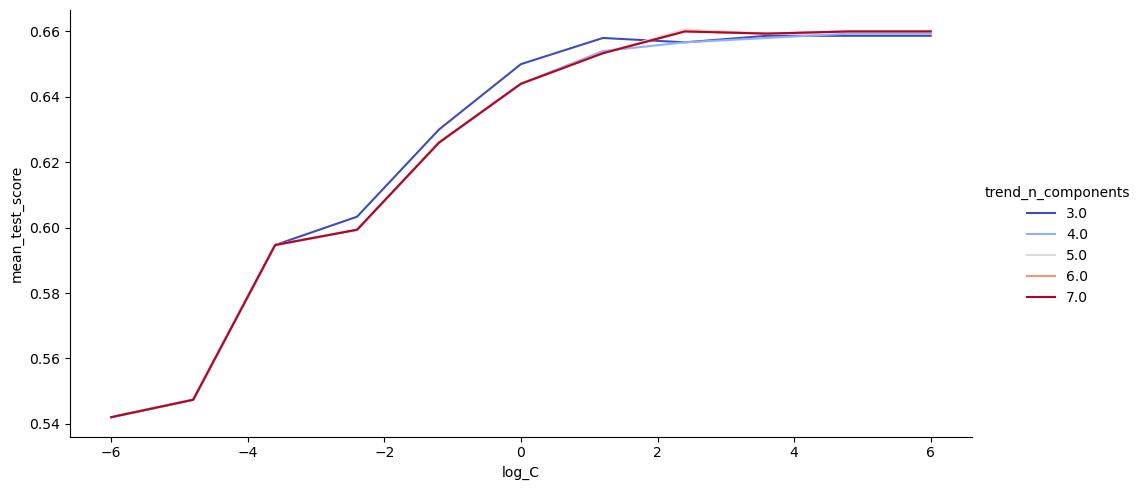

In [372]:
sns.relplot(data=mod12_cv_summary, x='log_C', y='mean_test_score', hue='trend_n_components',
           kind='line', palette='coolwarm', aspect=2)

plt.show()

**Extracting and adding the best model to a dataframe**

In [373]:
mod12_best_result = mod12_cv_summary.\
loc[mod12_cv_summary.mean_test_score == mod12_cv_summary.mean_test_score.max(), :].copy()

In [374]:
mod12_best_result['model_name'] = 'Mod-12: Trend data with PCA'

In [375]:
mod12_best_result

,C,trend_n_components,mean_test_score,std_test_score,mean_test_score_se,log_C,model_name
37,11.023176,5.0,0.660667,0.043889,0.011332,2.4,Mod-12: Trend data with PCA


### Model - 13
**PCA on trend and sesonal values and interact**

In [376]:
from sklearn.preprocessing import PolynomialFeatures

In [377]:
mod13_seasonal_days = ['seasonal_week_' + str(d).zfill(3) for d in range(1, 157+1)]

In [378]:
mod13_trend_days = ['trend_week_' + str(d).zfill(3) for d in range(1, 157+1)]

In [379]:
mod13_df = df_use.loc[:, ['sector'] + mod13_seasonal_days + mod13_trend_days].copy()

In [380]:
mod13_df['outcome'] = np.where( df_use.apr_rel_close > df_use.day_756, 'event', 'non-event')

In [381]:
mod13_df.outcome.value_counts(normalize=True)

event        0.542
non-event    0.458
Name: outcome, dtype: float64

In [382]:
mod13_inputs_df = mod13_df.loc[:, ['sector'] + mod13_seasonal_days + mod13_trend_days].copy()

In [383]:
mod13_output_df = mod13_df.loc[:, ['outcome']].copy()

In [384]:
mod13_ytrain = mod13_output_df.outcome.to_numpy().ravel()

In [385]:
mod13_ses_transform = Pipeline(steps=[ ('std_ses', StandardScaler()),
                                       ('pca_ses', PCA()) ])

In [386]:
mod13_trend_transform = Pipeline(steps=[ ('std_trend', StandardScaler()),
                                         ('pca_trend', PCA()) ])

In [387]:
mod13_cat_input = mod13_inputs_df.select_dtypes('object').columns.to_list()

In [388]:
mod13_cat_transform = Pipeline(steps= [('dummy', OneHotEncoder(drop='first')) ])

In [389]:
mod13_ses_trend_transform = ColumnTransformer(transformers=[ ('ses_pca', mod13_ses_transform, mod13_seasonal_days),
                                                             ('trend_pca', mod13_trend_transform, mod13_trend_days )])

In [390]:
mod13_interact_transform = Pipeline(steps=[ ('ses_trend_interact', mod13_ses_trend_transform),
                                            ('make_poly', PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)),
                                            ('std_interact', StandardScaler()),
                                            ('pca_interact', PCA()) ])

In [391]:
mod13_prepo_transform = ColumnTransformer(transformers=[ ('interact_trans', mod13_interact_transform, mod13_seasonal_days + mod13_trend_days),
                                                         ('cat', mod13_cat_transform, mod13_cat_input)])

In [392]:
mod13_prepo_transform.fit_transform(mod13_inputs_df).shape

(500, 324)

In [393]:
mod13_wflow = Pipeline(steps=[ ('prepo', mod13_prepo_transform),
                               ('enet', enet_to_fit)])

**Fixed the n_components for sesonal and trend data to 40 and found that out of (10, 20, 30), 10 was the best parameter to be used for the interaction PCA n_components. Fixed the interaction PCA n_components to 10 and then searched over several values of n_component for trend and ses data.**

In [394]:
mod13_enet_grid = {'prepo__interact_trans__ses_trend_interact__ses_pca__pca_ses__n_components': [15, 40, 70],
                   'prepo__interact_trans__ses_trend_interact__trend_pca__pca_trend__n_components': [15, 40, 70],
                   'prepo__interact_trans__pca_interact__n_components': [10],
                   'enet__C': np.exp(np.linspace(-6, 6, num=11)),
                   'enet__l1_ratio': np.linspace(0, 1, num=5)}

In [395]:
mod13_enet_search = GridSearchCV(mod13_wflow, mod13_enet_grid, cv=my_cv)

In [396]:
# mod13_t0 = time.time()

# mod13_enet_search_result = mod13_enet_search.fit(mod13_inputs_df, mod13_ytrain)

# mod13_t1 = time.time()

In [397]:
# (mod13_t1 - mod13_t0) / 60

**Save Model**

In [398]:
# pickle.dump(mod13_enet_search_result, open('mod13_temp.sav', 'wb'))

**Load Model**

In [399]:
mod13_enet_search_result = pickle.load(open('mod13_temp.sav', 'rb'))

In [400]:
mod13_enet_search_result.best_params_

{'enet__C': 0.09071795328941247,
 'enet__l1_ratio': 0.0,
 'prepo__interact_trans__pca_interact__n_components': 10,
 'prepo__interact_trans__ses_trend_interact__ses_pca__pca_ses__n_components': 70,
 'prepo__interact_trans__ses_trend_interact__trend_pca__pca_trend__n_components': 70}

In [401]:
mod13_enet_search_result.best_score_

0.6966666666666668

**Visualizing the result**

In [402]:
mod13_cv_summary = pd.DataFrame({'C': mod13_enet_search_result.cv_results_['param_enet__C'].data.astype('float64'),
                                 'l1_ratio': mod13_enet_search_result.cv_results_['param_enet__l1_ratio'].data.astype('float64'),
                                 'ses_n_components': mod13_enet_search_result.cv_results_['param_prepo__interact_trans__ses_trend_interact__ses_pca__pca_ses__n_components'].data.astype('float64'),
                                 'trend_n_components': mod13_enet_search_result.cv_results_['param_prepo__interact_trans__ses_trend_interact__trend_pca__pca_trend__n_components'].data.astype('float64'),
                                 'ses_trend_n_components': mod13_enet_search_result.cv_results_['param_prepo__interact_trans__pca_interact__n_components'].data.astype('float64'),
                                 'mean_test_score': mod13_enet_search_result.cv_results_['mean_test_score'],
                                 'std_test_score': mod13_enet_search_result.cv_results_['std_test_score'] })

In [403]:
mod13_cv_summary['mean_test_score_se'] = mod13_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [404]:
mod13_cv_summary['log_C'] = np.log( mod13_cv_summary.C )

In [405]:
mod13_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,C,l1_ratio,ses_n_components,trend_n_components,ses_trend_n_components,mean_test_score,std_test_score,mean_test_score_se,log_C
143,0.090718,0.00,70.0,70.0,10.0,0.696667,0.052111,0.013455,-2.4
404,36.598234,1.00,70.0,70.0,10.0,0.696000,0.044989,0.011616,3.6
323,11.023176,0.00,70.0,70.0,10.0,0.695333,0.045294,0.011695,2.4
395,36.598234,0.75,70.0,70.0,10.0,0.695333,0.046313,0.011958,3.6
386,36.598234,0.50,70.0,70.0,10.0,0.695333,0.046313,0.011958,3.6


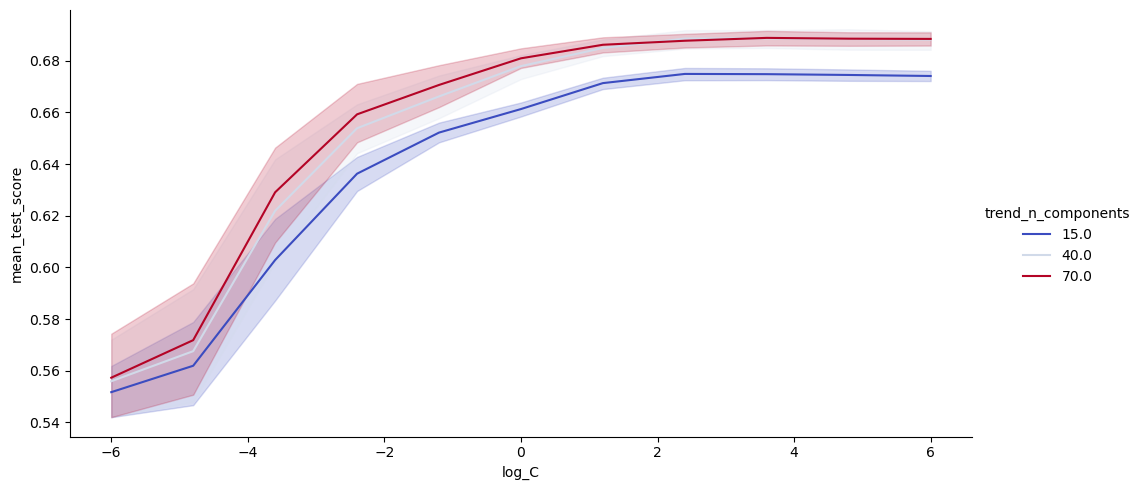

In [406]:
sns.relplot(data=mod13_cv_summary, x='log_C', y='mean_test_score', hue='trend_n_components',
           kind='line', palette='coolwarm', aspect=2)

plt.show()

In [407]:
mod13_best_result = mod13_cv_summary.\
loc[mod13_cv_summary.mean_test_score == mod13_cv_summary.mean_test_score.max(), :].copy()

In [408]:
mod13_best_result['model_name'] = 'Mod-13: Ses + Trend Interaction'

In [409]:
mod13_best_result

,C,l1_ratio,ses_n_components,trend_n_components,ses_trend_n_components,mean_test_score,std_test_score,mean_test_score_se,log_C,model_name
143,0.090718,0.0,70.0,70.0,10.0,0.696667,0.052111,0.013455,-2.4,Mod-13: Ses + Trend Interaction


### Comparing all models

We will not include `model-1` and `model-5` becasue both models are trained on just 2020 data and the output is  unevenly distributed. 

`Model-5` perfroms so bad on test data set that even though the train data have 85% non-event the accuracy is about 75%

In [410]:
results_df = pd.concat([mod2_best_result.loc[:, ['model_name', 'mean_test_score', 'mean_test_score_se']].copy(),
                        mod3_best_result.loc[:, ['model_name', 'mean_test_score', 'mean_test_score_se']].copy(),
                        mod4_best_result.loc[:, ['model_name', 'mean_test_score', 'mean_test_score_se']].copy(),
                        mod6_best_result.loc[:, ['model_name', 'mean_test_score', 'mean_test_score_se']].copy(),
                        mod7_best_result.loc[:, ['model_name', 'mean_test_score', 'mean_test_score_se']].copy(),
                        mod8_best_result.loc[:, ['model_name', 'mean_test_score', 'mean_test_score_se']].copy(),
                        mod9_best_result.loc[:, ['model_name', 'mean_test_score', 'mean_test_score_se']].copy(),
                        mod10_best_result.loc[:, ['model_name', 'mean_test_score', 'mean_test_score_se']].copy(),
                        mod11_best_result.loc[:, ['model_name', 'mean_test_score', 'mean_test_score_se']].copy(),
                        mod12_best_result.loc[:, ['model_name', 'mean_test_score', 'mean_test_score_se']].copy(),
                        mod13_best_result.loc[:, ['model_name', 'mean_test_score', 'mean_test_score_se']].copy()])

In [411]:
results_df.reset_index(drop=True, inplace=True)

In [412]:
results_df

,model_name,mean_test_score,mean_test_score_se
0,Mod-2: 2021 data,0.728000,0.009151
1,Mod-3: 2022 data,0.686667,0.013619
2,Mod-4: All data,0.712667,0.011906
3,Mod-6: 2021 with PCA,0.724000,0.010276
4,Mod-7: 2022 with PCA,0.697333,0.012346
5,Mod-8: All data with PCA,0.713333,0.012708
6,Mod-9: All + ses data with PCA,0.712000,0.010507
7,Mod-10: All + trend data with PCA,0.707333,0.010728
8,Mod-11: Ses data with PCA,0.690000,0.010954
9,Mod-12: Trend data with PCA,0.660667,0.011332


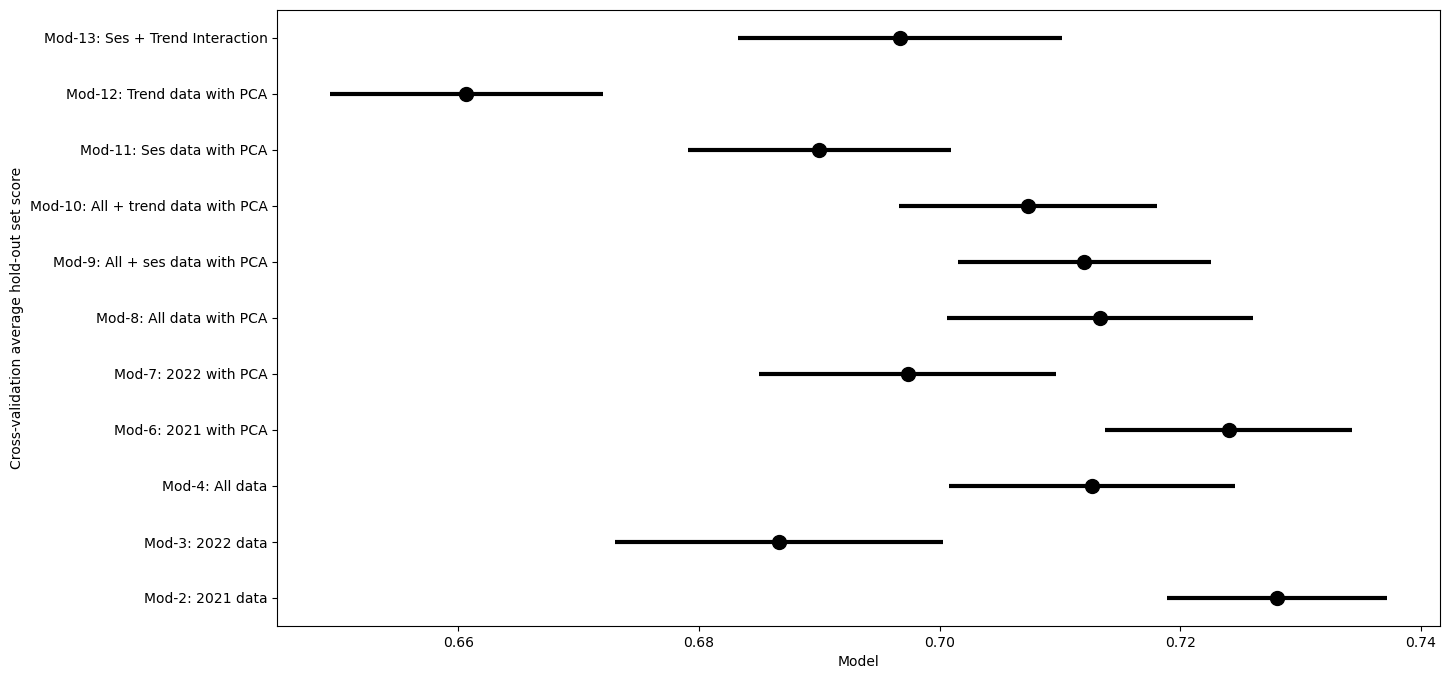

In [413]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.errorbar(y = results_df.model_name,
            x = results_df.mean_test_score,
            xerr = results_df.mean_test_score_se,
            fmt = 'o', color = 'black', ecolor = 'black', 
            elinewidth=3, ms=10)

ax.set_ylabel('Cross-validation average hold-out set score')
ax.set_xlabel('Model')

plt.show()